# Multiclass semantic segmentation using DeepLabV3+.

Problem statement:
Assign semantic labels to every pixel in an image.

The Crowd Instance-level Human Parsing Dataset will be used in this project. It has 38,280 diverse human images. Each image is labeled with pixel-wise annotations for 20 categories, along with instance-level identification.

In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!gdown "1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t"
!unzip -q instance-level-human-parsing.zip

Downloading...
From: https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz&confirm=t
To: /content/instance-level-human-parsing.zip
100% 2.91G/2.91G [00:35<00:00, 82.9MB/s]


In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
NUM_CLASSES = 20
DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50

train_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "Images/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "Category_ids/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <_BatchDataset element_spec=(TensorSpec(shape=(4, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 512, 512, 1), dtype=tf.float32, name=None))>


In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [ ]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Epoch 1/15
250/250 [==============================] - 128s 375ms/step - loss: 1.0186 - accuracy: 0.6793 - val_loss: 1.1824 - val_accuracy: 0.6493
Epoch 2/15
250/250 [==============================] - 93s 371ms/step - loss: 0.8805 - accuracy: 0.7192 - val_loss: 1.2049 - val_accuracy: 0.6251
Epoch 3/15
250/250 [==============================] - 94s 376ms/step - loss: 0.7889 - accuracy: 0.7471 - val_loss: 1.1223 - val_accuracy: 0.6378
Epoch 4/15
250/250 [==============================] - 93s 371ms/step - loss: 0.7292 - accuracy: 0.7657 - val_loss: 0.9107 - val_accuracy: 0.7077
Epoch 5/15
250/250 [==============================] - 94s 375ms/step - loss: 0.7046 - accuracy: 0.7729 - val_loss: 0.9144 - val_accuracy: 0.7004
Epoch 6/15
250/250 [==============================] - 94s 376ms/step - loss: 0.6233 - accuracy: 0.8000 - val_loss: 0.8441 - val_accuracy: 0.7279
Epoch 7/15
250/250 [==============================] - 94s 376ms/step - loss: 0.5688 - accuracy: 0.8172 - val_loss: 0.8216 - val_a

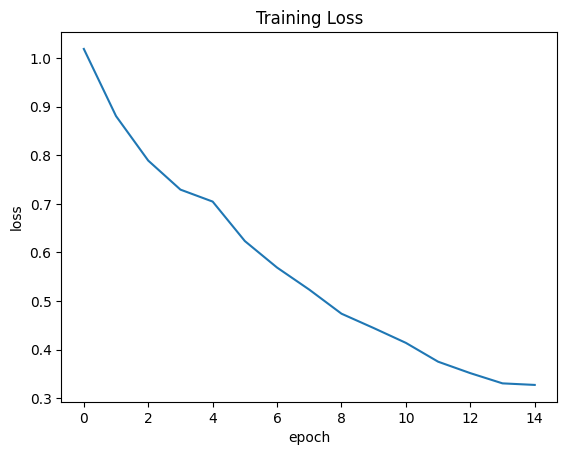

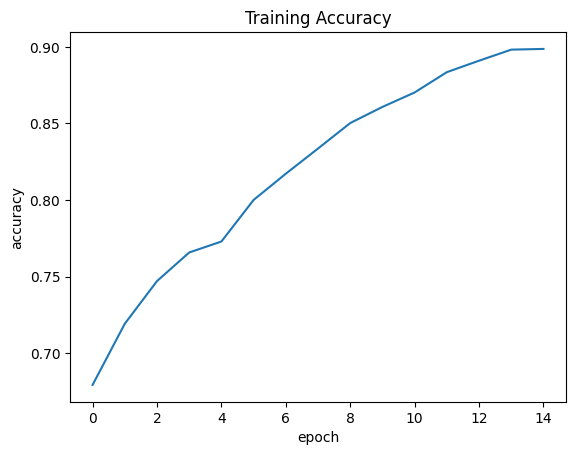

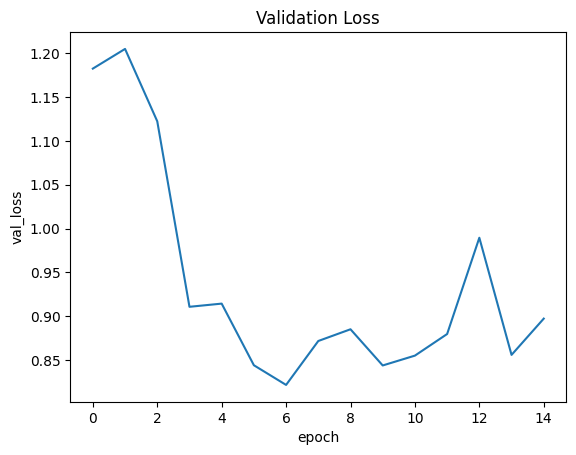

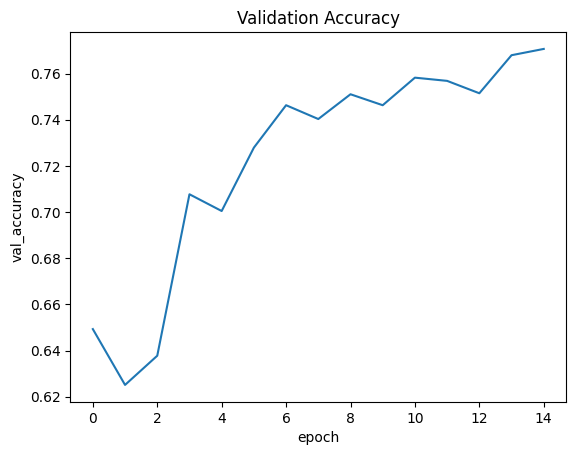

In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=15)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
# Loading the Colormap
colormap = loadmat(
    "./instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat"
)["colormap"]
colormap = colormap * 100
colormap = colormap.astype(np.uint8)


def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 20)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

1/1 [==============================] - 0s 46ms/step


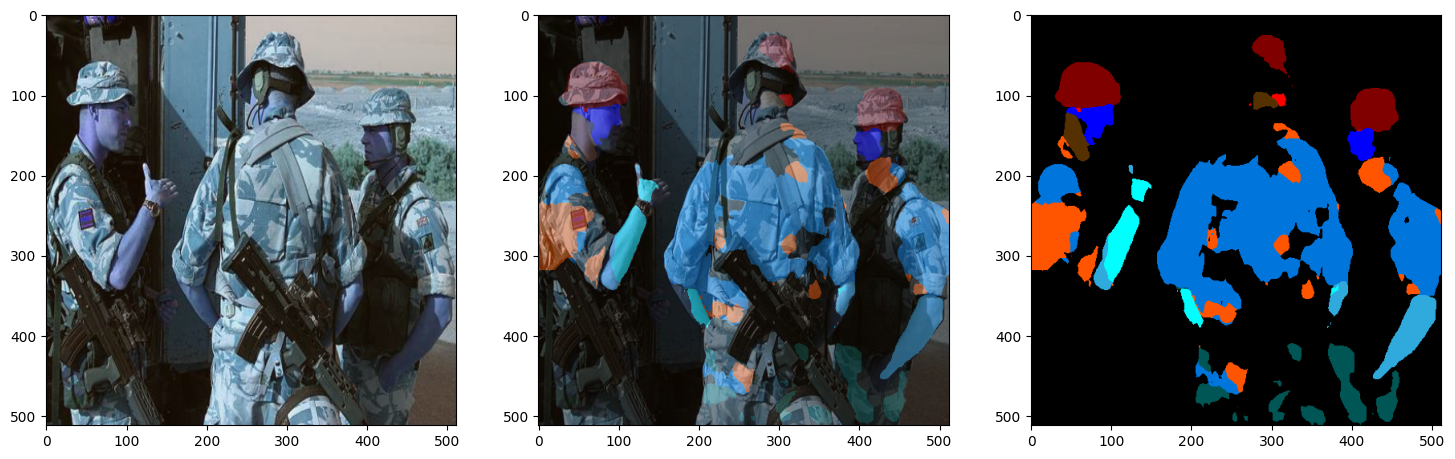

1/1 [==============================] - 0s 38ms/step


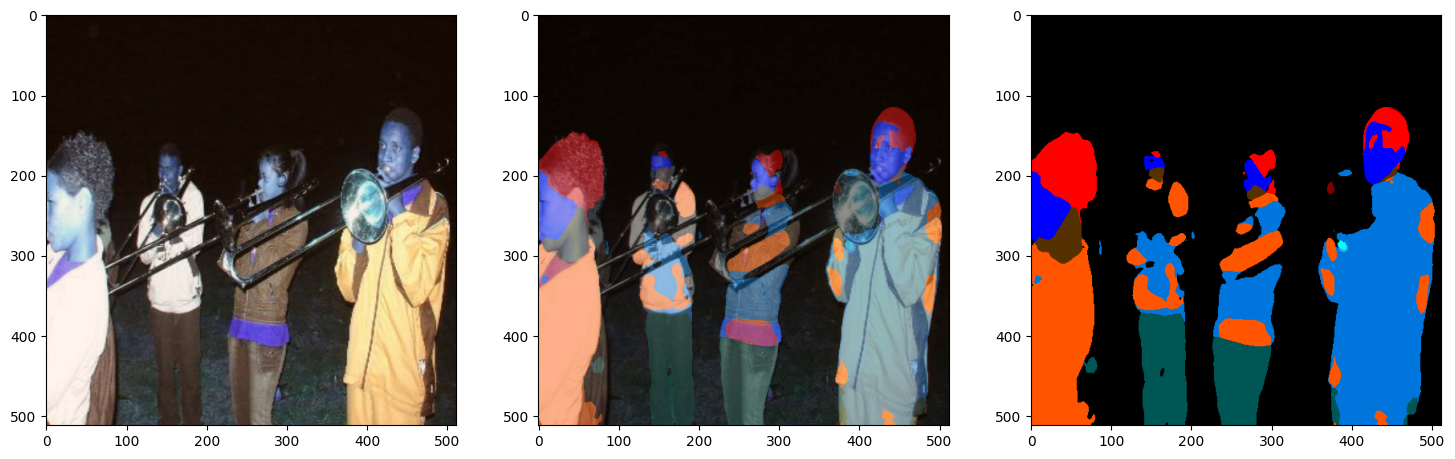

1/1 [==============================] - 0s 42ms/step


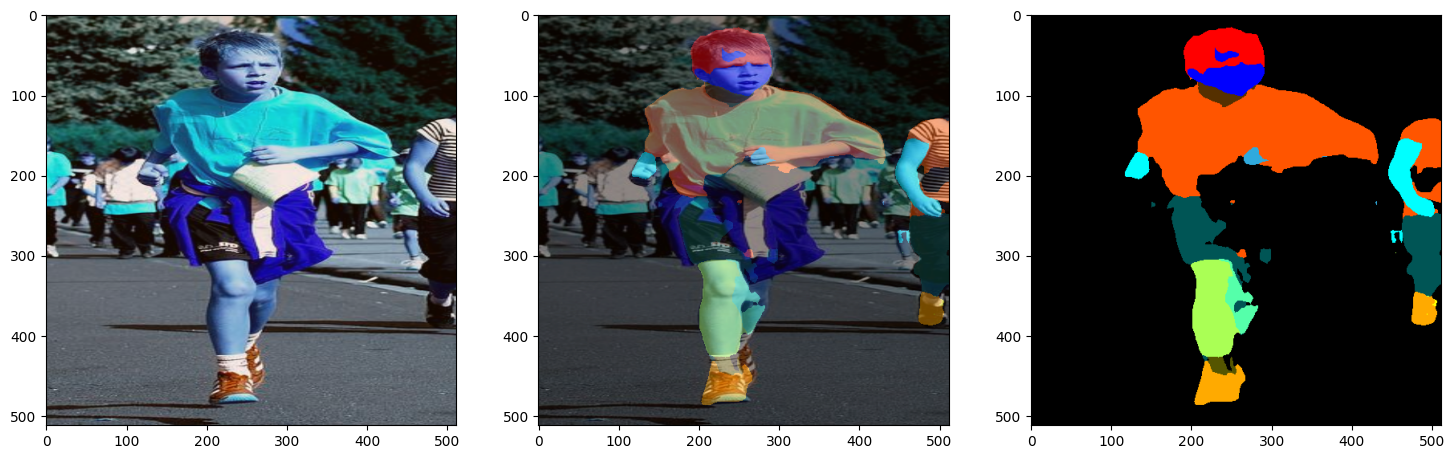

1/1 [==============================] - 0s 47ms/step


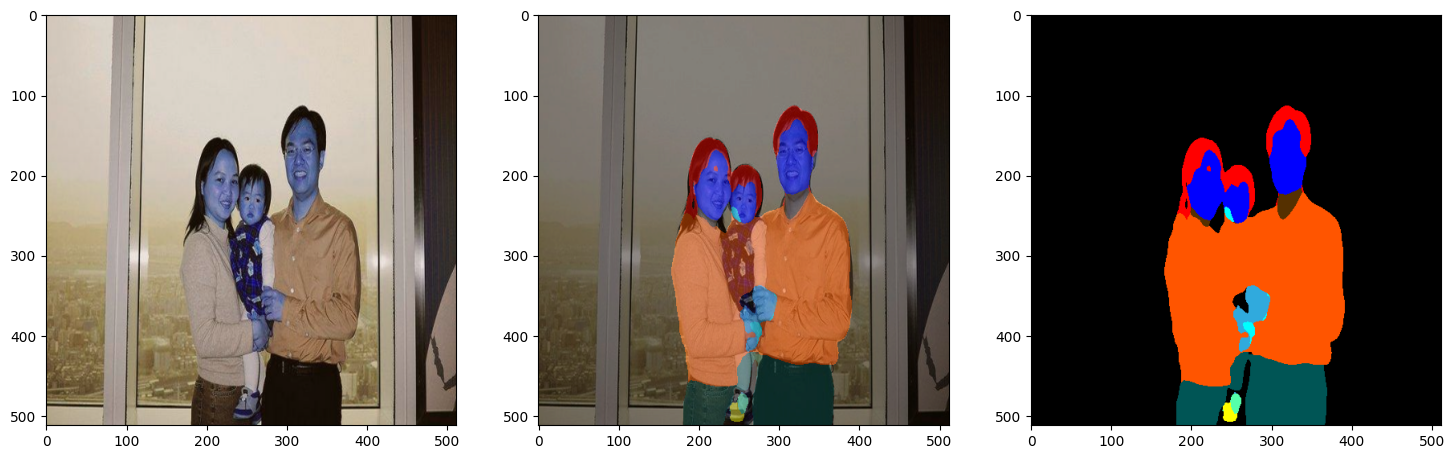

In [ ]:
plot_predictions(train_images[-4:], colormap, model=model)